In [1]:
import argparse
import os.path as osp
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np

import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import torch_geometric.transforms as T
from torch_geometric.datasets import CitationFull, WikipediaNetwork, Amazon, Coauthor
from torch_geometric.logging import log
from torch_geometric.data import Data
from torch_geometric.nn import SGConv, SAGEConv, WLConv, WLConvContinuous
from gcn_conv import GCNConv
from gat_conv import GATConv
from torch_geometric.utils import degree, add_remaining_self_loops, k_hop_subgraph, to_networkx, subgraph
from torch_scatter import scatter, scatter_mean, scatter_sum
import torch_sparse
import networkx as nx

from utils import *
import json
from copy import copy
import os
from os import environ

# %load_ext autoreload
# %autoreload 2

In [2]:
environ['CUDA_LAUNCH_BLOCKING'] = "1"
dataset = environ.get('dataset', 'CiteSeer')
num_gnn_layers = int(environ.get('num_gnn_layers', '3'))

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default=dataset)
parser.add_argument('--hidden_channels', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=1000)
parser.add_argument('--num_gnn_layers', type=int, default=num_gnn_layers)
parser.add_argument('--num_mlp_layers', type=int, default=num_gnn_layers)
args = parser.parse_args("")

if torch.cuda.is_available():
    device = torch.device('cuda:6')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [4]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [5]:
seed_everything(42)
transform = T.Compose([
                # T.LargestConnectedComponents(),
                T.RandomNodeSplit(),
                T.NormalizeFeatures()
            ])

if args.dataset in ['Cora_ML', 'CiteSeer']: 
    path = osp.join('.', 'data', 'CitationFull')
    dataset = CitationFull(path, args.dataset, transform=transform)
elif args.dataset in ['CS', 'Physics']:
    path = osp.join('.', 'data', 'Coauthor')
    dataset = Coauthor(path, args.dataset, transform=transform)
elif args.dataset in ['Photo', 'Computers']:
    path = osp.join('.', 'data', 'Amazon')
    dataset = Amazon(path, args.dataset, transform=transform)
elif args.dataset in ['chameleon', 'squirrel']:
    path = osp.join('.', 'data', 'WikipediaNetwork')
    dataset = WikipediaNetwork(path, args.dataset, transform=transform)

data = dataset[0].to(device)
threshold = 100
seeds_list = [5, 340] #, 87, 23, 409, 104, 278, 12, 43, 76]

## Model architectures

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type='mlp', linear=False):
        super().__init__()
        
        self.conv_list = torch.nn.ModuleList([torch.nn.Linear(in_channels, hidden_channels)] + \
                                       [torch.nn.Linear(hidden_channels, hidden_channels) for i in range(args.num_mlp_layers - 2)] + \
                                       [torch.nn.Linear(hidden_channels, out_channels)])
        self.model_type = model_type
        self.linear = linear

    def forward(self, x, edge_index, edge_weight=None):
        for idx, conv in enumerate(self.conv_list):
            # x = F.dropout(x, p=0.5, training=self.training)
            if idx != 0 and not self.linear:
                x = x.relu()
            x = conv(x)
            
        return x
    
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type='gcn', linear=False):
        super().__init__()
        
        if model_type == 'gcn':
            conv = GCNConv
            conv_type = "sym"
            self.conv_list = torch.nn.ModuleList([conv(in_channels, in_channels, hidden_channels, conv=conv_type)] + \
                                           [conv(in_channels, hidden_channels, hidden_channels, conv=conv_type) for i in range(args.num_gnn_layers - 2)] + \
                                           [conv(in_channels, hidden_channels, out_channels, conv=conv_type)])
            
        elif model_type == 'sage':
            conv = GCNConv
            conv_type = "rw"
            self.conv_list = torch.nn.ModuleList([conv(in_channels, in_channels, hidden_channels, conv=conv_type)] + \
                                           [conv(in_channels, hidden_channels, hidden_channels, conv=conv_type) for i in range(args.num_gnn_layers - 2)] + \
                                           [conv(in_channels, hidden_channels, out_channels, conv=conv_type)])
#             conv = SAGEConv
#             conv_type = None
#             self.conv_list = torch.nn.ModuleList([conv(in_channels, hidden_channels)] + \
#                                            [conv(hidden_channels, hidden_channels) for i in range(args.num_gnn_layers - 2)] + \
#                                            [conv(hidden_channels, out_channels)])
            
        elif 'gat' in model_type:
            conv = GATConv
            self.conv_list = torch.nn.ModuleList([conv(in_channels, in_channels, hidden_channels)] + \
                                           [conv(in_channels, hidden_channels, hidden_channels) for i in range(args.num_gnn_layers - 2)] + \
                                           [conv(in_channels, hidden_channels, out_channels)])
        
        elif model_type == 'sgconv':
            conv = SGConv
            conv_type = None
            self.conv_list = torch.nn.ModuleList([conv(in_channels, hidden_channels)] + \
                                           [conv(hidden_channels, hidden_channels) for i in range(args.num_gnn_layers - 2)] + \
                                           [conv(hidden_channels, out_channels)])
        
        # self.bn_list = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_channels) for i in range(args.num_gnn_layers - 1)])
        
        # self.mlp = MLP(hidden_channels, hidden_channels, out_channels)
        self.model_type = model_type
        self.linear = linear

    def forward(self, x, edge_index, edge_weight=None, get_att=False):
        atts = []
        x0 = torch.clone(x)
        for idx, conv in enumerate(self.conv_list):
            # x = F.dropout(x, p=0.5, training=self.training)
            if idx != 0 and not self.linear:
                x = x.relu()
            if get_att:
                x, alpha = conv(x, x0, edge_index, edge_weight, get_att=True)
                atts.append(alpha)
            else:
                x = conv(x, x0, edge_index, edge_weight)
#             if idx != len(self.conv_list) - 1:
#                 x = self.bn_list[idx](x)
            
        # return self.mlp(x, edge_index, edge_weight)
        if get_att:
            return x, atts
        return x

In [7]:
def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    
    if model.model_type.startswith('fair-'):
        pred = F.log_softmax(out, dim=1)[data.train_mask]
        target = data.y[data.train_mask]
        err = -pred[range(target.size(0)), target].flatten()
        
        # compute standard deviation
        deg = degree(data.edge_index[0], num_nodes=data.x.size(0))[data.train_mask]
        err_by_deg = scatter_mean(err, deg.long())
        count_by_deg = scatter_sum(torch.ones_like(data.y)[data.train_mask].float(), deg.long())
        err_by_deg = err_by_deg[count_by_deg > 0]
        
        lam = float(model.model_type.split('-')[-1])
        loss += lam * torch.std(err_by_deg)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    return float(loss)


@torch.no_grad()
def test(model):
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

## Inspect data

In [8]:
# edge_index = data.edge_index
# edge_weight = torch.ones_like(edge_index[0]).float()
# C_u = get_compatibility_matrix(data.y, edge_index, edge_weight)
# fig, ax = plt.subplots()
# ax = sns.heatmap(C_u, annot=C_u)
# plt.title(dataset.name + ", u")
# plt.show()

In [9]:
wl = WLConv()
_, c = data.x.unique(dim=0, return_inverse=True)
for _ in range(args.num_gnn_layers):
    c = wl(c, data.edge_index)

X_uniq, inv = c[data.train_mask].unique(dim=0, return_inverse=True)
inv_uniq = inv.unique().tolist()
maj_pred = torch.zeros_like(data.y[data.train_mask])

for u in inv_uniq:
    maj_pred[inv == u] = torch.mode(data.y[data.train_mask][inv == u]).values

best_acc = ((maj_pred == data.y[data.train_mask]).sum() / data.y[data.train_mask].size(0)).item()

## Train models

In [10]:
models = {}
overfit_models = {}

acc_by_grads = {}

model_list = [
                'sage', \
                'gcn', \
                'gat', \
            ]

# for alpha in [1.0, 2.0, 4.0, 8.0, 12.0]:
#     model_list.append('fair-gat-{}'.format(str(alpha)))

low_deg_spreads = {}
high_deg_spreads = {}

low_deg_losses = {}
high_deg_losses = {}

loss_by_deg = {}

low_deg_svd = {}
high_deg_svd = {}

for model_name in model_list:
    
    models[model_name] = {}
    overfit_models[model_name] = {}

    acc_by_grads[model_name] = {}
    
    low_deg_spreads[model_name] = {}
    high_deg_spreads[model_name] = {}

    low_deg_losses[model_name] = {}
    high_deg_losses[model_name] = {}

    loss_by_deg[model_name] = {}

    low_deg_svd[model_name] = {}
    high_deg_svd[model_name] = {}
    
    for seed in seeds_list:
        
        seed_everything(seed)
        print()
        print(model_name, seed)

        if model_name == 'mlp':
            model = MLP(
                in_channels=dataset.num_features,
                hidden_channels=args.hidden_channels,
                out_channels=dataset.num_classes,
                model_type=model_name
            ).to(device)
        else:
            model = GNN(
                in_channels=dataset.num_features,
                hidden_channels=args.hidden_channels,
                out_channels=dataset.num_classes,
                model_type=model_name
            ).to(device)
        
        acc_by_grads[model_name][seed] = []
        
        low_deg_spreads[model_name][seed] = []
        high_deg_spreads[model_name][seed] = []

        low_deg_losses[model_name][seed] = []
        high_deg_losses[model_name][seed] = []

        low_deg_svd[model_name][seed] = []
        high_deg_svd[model_name][seed] = []
        
        loss_by_deg[model_name][seed] = []
    
        optimizer = torch.optim.Adam([
            dict(params=conv.parameters(), weight_decay=0) for conv in model.conv_list
        ], lr=args.lr)
        scheduler = StepLR(optimizer, step_size=250, gamma=0.25)

        train_acc = 0
        best_val_acc = test_acc = 0
        best_model = None
        times = []

        edge_index = data.edge_index
        deg = degree(edge_index[0], num_nodes=data.x.size(0))

        epoch = 1
        while epoch < args.epochs + 1:
            out = model(data.x, data.edge_index, data.edge_attr)

            degs_split = deg[data.test_mask]

            # high_cutoff = torch.quantile(degs_split, q=1-ratio)
            # high_degs_mask = degs_split >= high_cutoff
            high_idx = torch.topk(degs_split, k=threshold)[1]
            high_degs_mask = torch.zeros_like(degs_split).bool()
            high_degs_mask[high_idx] = True

            # low_cutoff = torch.quantile(degs_split, q=ratio)
            # low_degs_mask = degs_split <= low_cutoff
            low_idx = torch.topk(-degs_split, k=threshold)[1]
            low_degs_mask = torch.zeros_like(degs_split).bool()
            low_degs_mask[low_idx] = True

            low_deg_spread, high_deg_spread = scatter(out[data.test_mask], high_degs_mask, low_degs_mask, data)
            low_deg_spreads[model_name][seed].append(low_deg_spread.item())
            high_deg_spreads[model_name][seed].append(high_deg_spread.item())
            
            pred = F.log_softmax(out, dim=1)
            target = data.y
            err = -pred[range(target.size(0)), target]

            train_degs = deg[data.train_mask]
            train_low_idx = torch.topk(-train_degs, k=threshold)[1]
            train_high_idx = torch.topk(train_degs, k=threshold)[1]

            low_deg_losses[model_name][seed].append(err[data.train_mask][train_low_idx].mean().item())
            high_deg_losses[model_name][seed].append(err[data.train_mask][train_high_idx].mean().item())

            if epoch == args.epochs:
                mask = data.test_mask
                U, S, V = torch.svd(out[mask])

                low_deg_svd[model_name][seed].append((U[:, 0][low_degs_mask].tolist(), U[:, 1][low_degs_mask].tolist(), data.y[mask][low_degs_mask].tolist()))
                high_deg_svd[model_name][seed].append((U[:, 0][high_degs_mask].tolist(), U[:, 1][high_degs_mask].tolist(), data.y[mask][high_degs_mask].tolist()))
                
            start = time.time()
            loss = train(model)
            train_acc, val_acc, tmp_test_acc = test(model)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                test_acc = tmp_test_acc
                best_model = model
            times.append(time.time() - start)
            
            total_norm = 0
            num_params = 0
            for p in model.parameters():
                total_norm += torch.abs(p.grad.detach().data).sum().item()
                num_params += p.grad.detach().data.numel()
            total_norm = total_norm / num_params
            acc_by_grads[model_name][seed].append((total_norm, train_acc))

            if epoch % 100 == 0:
                log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
            epoch += 1

        models[model_name][seed] = best_model
        overfit_models[model_name][seed] = model
        
        out = models[model_name][seed](data.x, data.edge_index, data.edge_attr)
        pred = F.log_softmax(out, dim=1)
        target = data.y
        err = -pred[range(target.size(0)), target]
        
#         pred = pred.argmax(dim=-1)
#         err = (pred != data.y).float()
                
        err_by_deg = torch.zeros(int(deg.max()) + 1, device=deg.device)
        count_by_deg = torch.zeros(int(deg.max()) + 1, device=deg.device)
        
        scatter_mean(err[data.test_mask], deg[data.test_mask].long(), out=err_by_deg)
        scatter_sum(torch.ones_like(data.y)[data.test_mask].float(), deg[data.test_mask].long(), out=count_by_deg)
        
        loss_by_deg[model_name][seed] = err_by_deg[count_by_deg > 0].tolist()
                
        print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')


sage 5
Epoch: 100, Loss: 0.0169, Train: 0.9923, Val: 0.8840, Test: 0.8980
Epoch: 200, Loss: 0.0157, Train: 0.9923, Val: 0.8840, Test: 0.8980
Epoch: 300, Loss: 0.0155, Train: 0.9923, Val: 0.8800, Test: 0.8980
Epoch: 400, Loss: 0.0155, Train: 0.9923, Val: 0.8820, Test: 0.8980
Epoch: 500, Loss: 0.0155, Train: 0.9923, Val: 0.8820, Test: 0.8980
Epoch: 600, Loss: 0.0154, Train: 0.9923, Val: 0.8820, Test: 0.8980
Epoch: 700, Loss: 0.0154, Train: 0.9923, Val: 0.8820, Test: 0.8980
Epoch: 800, Loss: 0.0154, Train: 0.9923, Val: 0.8820, Test: 0.8980
Epoch: 900, Loss: 0.0154, Train: 0.9923, Val: 0.8820, Test: 0.8980
Epoch: 1000, Loss: 0.0154, Train: 0.9923, Val: 0.8820, Test: 0.8980
Median time per epoch: 0.0210s

sage 340
Epoch: 100, Loss: 0.0169, Train: 0.9923, Val: 0.8840, Test: 0.9000
Epoch: 200, Loss: 0.0159, Train: 0.9923, Val: 0.8820, Test: 0.9000
Epoch: 300, Loss: 0.0156, Train: 0.9923, Val: 0.8840, Test: 0.9000
Epoch: 400, Loss: 0.0155, Train: 0.9923, Val: 0.8840, Test: 0.9000
Epoch: 500, 

In [11]:
with open('plot_data/{}_{}.json'.format(args.dataset, args.num_gnn_layers), 'w') as fout:
    json.dump([loss_by_deg, \
               acc_by_grads, \
              low_deg_svd, \
              high_deg_svd, \
              low_deg_spreads, \
              high_deg_spreads, \
              low_deg_losses, \
              high_deg_losses], fout)

In [12]:
with open('plot_data/{}_{}.json'.format(args.dataset, args.num_gnn_layers), 'r') as fout:
    [loss_by_deg, \
      acc_by_grads, \
      low_deg_svd, \
      high_deg_svd, \
      low_deg_spreads, \
      high_deg_spreads, \
      low_deg_losses, \
      high_deg_losses] = json.load(fout)

## Plots and Results

In [13]:
matplotlib.rcParams.update({'font.size': 20})

In [14]:
def model_name_map(model_name):
    if model_name == 'gcn':
        return 'SYM'
    elif model_name == 'sage':
        return 'RW'
    elif model_name == 'gat':
        return 'ATT'
    elif 'fair-' in model_name:
        return r'FAIR ATT ($\lambda$ = {})'.format(model_name.split('-')[-1])
    else:
        return 'MLP'

In [15]:
unfair_models_to_plot = [model_name for model_name in model_list if not model_name.startswith('fair-')]

fair_models_to_plot = [model_name for model_name in model_list if model_name.startswith('fair-')]

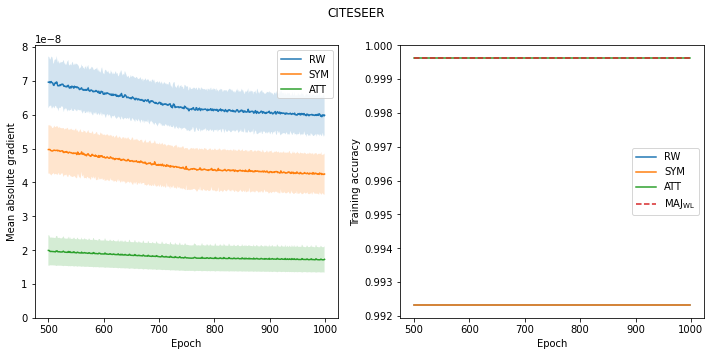

In [16]:
matplotlib.rcParams.update({'font.size': 16})

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 5))

for model_name in unfair_models_to_plot:
    grads = torch.tensor([[e[0] for e in acc_by_grads[model_name][seed]] for seed in acc_by_grads[model_name]])
    accs = torch.tensor([[e[1] for e in acc_by_grads[model_name][seed]] for seed in acc_by_grads[model_name]])
    
    grads_y = np.array(grads.mean(dim=0).tolist())
    grads_y_err = np.array(grads.std(dim=0).tolist())
    accs_y = np.array(accs.mean(dim=0).tolist())
    accs_y_err = np.array(accs.std(dim=0).tolist())
    x = np.array(range(len(grads_y)))
    
    cutoff = args.epochs - 500
    ax1.plot(x[cutoff:], grads_y[cutoff:], label=model_name_map(model_name))
    ax1.fill_between(x[cutoff:], (grads_y-grads_y_err)[cutoff:], (grads_y+grads_y_err)[cutoff:],
                            alpha=0.2, # edgecolor='C1', facecolor='C1',
                            linewidth=4, linestyle='dashdot', antialiased=True)
    
    ax2.plot(x[cutoff:], accs_y[cutoff:], label=model_name_map(model_name))
    ax2.fill_between(x[cutoff:], (accs_y-accs_y_err)[cutoff:], (accs_y+accs_y_err)[cutoff:],
                            alpha=0.2, # edgecolor='C1', facecolor='C1',
                            linewidth=4, linestyle='dashdot', antialiased=True)
    

ax2.plot(x[cutoff:], [best_acc for _ in x[cutoff:]], linestyle='dashed', label=r"${\mathrm{MAJ}}_{\mathrm{WL}}$")

ax1.set(ylim=0, xlabel='Epoch', ylabel='Mean absolute gradient')
ax2.set(xlabel='Epoch', ylabel='Training accuracy')
ax1.legend()
ax2.legend()
plt.suptitle(args.dataset.upper())
plt.tight_layout()
plt.savefig('plots/{}_{}_loss_vs_grad.pdf'.format(args.dataset, args.num_gnn_layers))
plt.show()

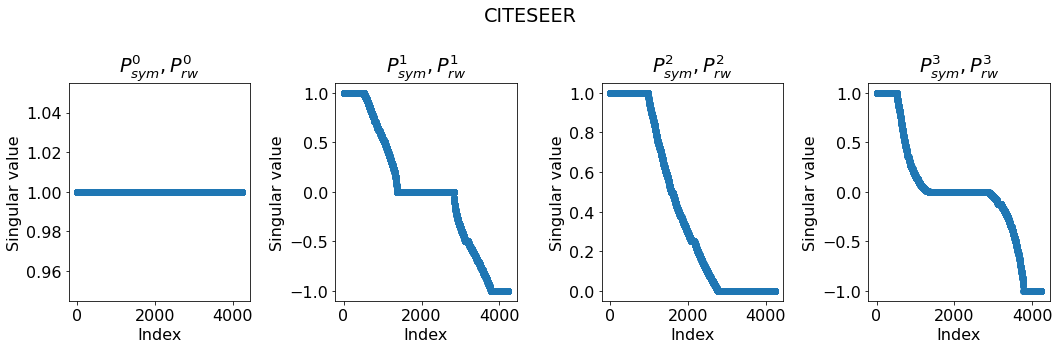

In [17]:
matplotlib.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, args.num_gnn_layers + 1, figsize=(15, 5))

# for norm_idx, (norm, norm_type) in enumerate([(gcn_norm, 'sym'), (sage_norm, 'rw')]):
edge_index = data.edge_index
edge_weight = torch.ones_like(edge_index[0]).float()
edge_weight = gcn_norm(edge_index, edge_weight, data.x.size(0))

for l in range(args.num_gnn_layers + 1):
    pow_edge_index, pow_edge_weight = power(edge_index, edge_weight, data.y.size(0), k=l)

    dense_adj = torch.sparse.FloatTensor(pow_edge_index, pow_edge_weight).detach().cpu().to_dense()
    eigvals = (-torch.sort(-torch.linalg.eigvals(dense_adj).real)[0]).tolist()
    axs[l].scatter(range(len(eigvals)), eigvals)

    axs[l].set(xlabel='Index', ylabel='Singular value', title=fr"$P_{{sym}}^{l}, P_{{rw}}^{l}$")

plt.suptitle(args.dataset.upper())
plt.tight_layout()
plt.savefig('plots/{}_{}_rank.pdf'.format(args.dataset, args.num_gnn_layers))
plt.show()

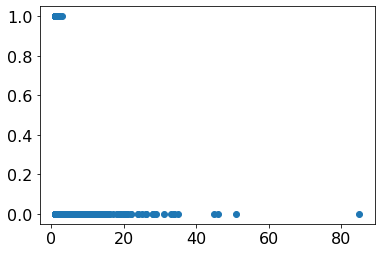

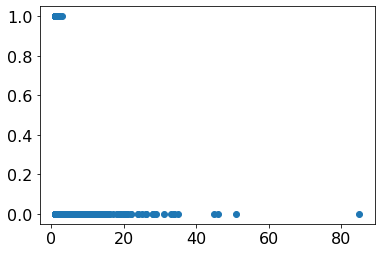

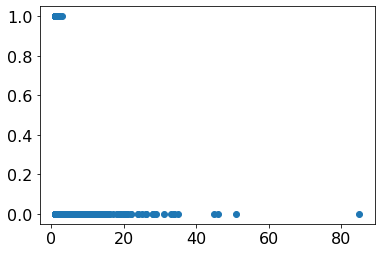

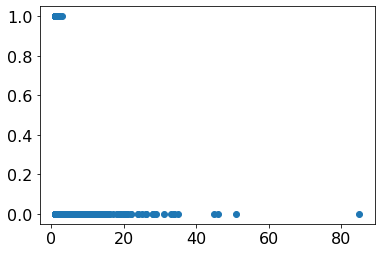

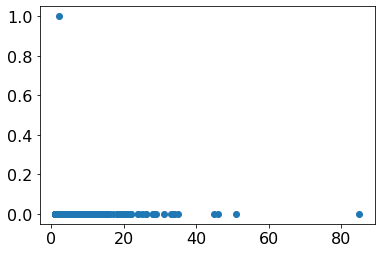

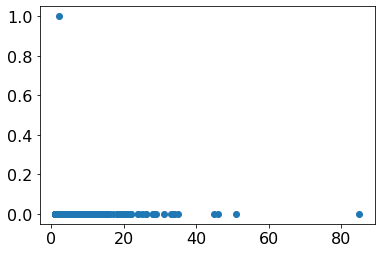

In [18]:
for model_name in overfit_models:
    for seed in overfit_models[model_name]:
        out = overfit_models[model_name][seed](data.x, data.edge_index, data.edge_attr)
        pred = F.log_softmax(out, dim=1).argmax(dim=-1)
        err = (pred[data.train_mask] != data.y[data.train_mask]).float()
        
        deg = degree(data.edge_index[0], num_nodes=data.x.size(0))[data.train_mask]
        
        plt.scatter(deg.tolist(), err.tolist())
        plt.show()

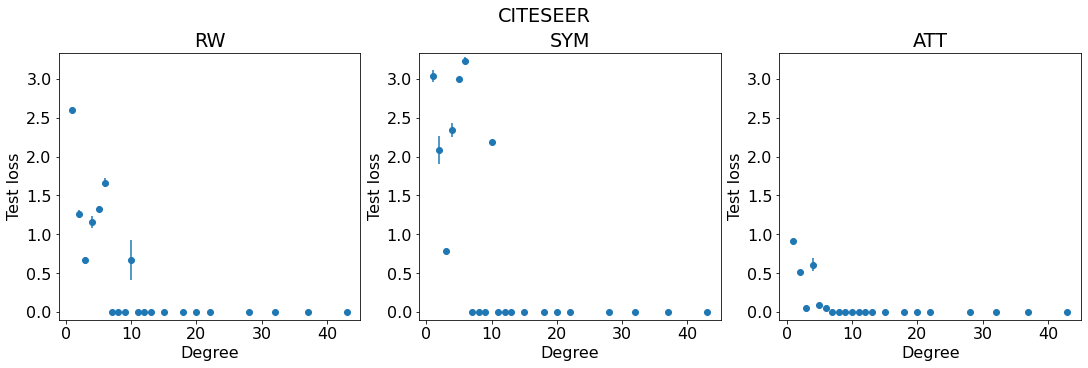

In [19]:
for models_to_plot in [unfair_models_to_plot]: #, fair_models_to_plot[::2]]:
    ylim_min = None
    ylim_max = None
    
    fig, axs = plt.subplots(1, len(models_to_plot), figsize=(5 * len(models_to_plot), 5), constrained_layout=True, sharex='row', sharey='row')
    
    for idx, model_name in enumerate(models_to_plot):

        deg_loss = [loss_by_deg[model_name][seed] for seed in loss_by_deg[model_name]]
        deg_loss_mean = np.array(deg_loss).mean(axis=0)
        deg_loss_std = np.array(deg_loss).std(axis=0)

        deg = degree(data.edge_index[0], num_nodes=data.x.size(0))
        count_by_deg = torch.zeros(int(deg.max()) + 1, device=deg.device)
        scatter_sum(torch.ones_like(data.y)[data.test_mask].float(), deg[data.test_mask].long(), out=count_by_deg)
        deg_x = torch.arange((deg.max()) + 1, device=deg.device)[count_by_deg > 0].tolist()

        axs[idx].errorbar(deg_x, deg_loss_mean, yerr=deg_loss_std, color='C0', fmt='o')
        axs[idx].set(xlabel='Degree', ylabel='Test loss', title=model_name_map(model_name))
        axs[idx].yaxis.set_tick_params(labelbottom=True)
        
        if ylim_min is None:
            ylim_min = min(deg_loss_mean) - 0.1
        else:
            ylim_min = min(ylim_min, min(deg_loss_mean) - 0.1)
            
        if ylim_max is None:
            ylim_max = max(deg_loss_mean) + 0.1
        else:
            ylim_max = max(ylim_max, max(deg_loss_mean) + 0.1)

    plt.setp(axs, ylim=(ylim_min, ylim_max))
        
    plt.suptitle(args.dataset.upper())
    plt.savefig('plots/{}_{}_loss_vs_deg.pdf'.format(args.dataset, args.num_gnn_layers))
    plt.show()

<ipython-input-20-b38065d2b385>:31: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[idx, 0].get_shared_x_axes().remove(axs[idx - 1, 0])
<ipython-input-20-b38065d2b385>:32: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[idx, 0].get_shared_y_axes().remove(axs[idx - 1, 0])
<ipython-input-20-b38065d2b385>:62: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[idx, 2].get_shared_x_axes().remove(axs[0, 2])
<ipython-input-20-b38065d2b385>:63: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[idx, 3].get_shared_x_axes().remove(axs[0, 3])
<ipython-input-20-b38065d2b385>:64: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and

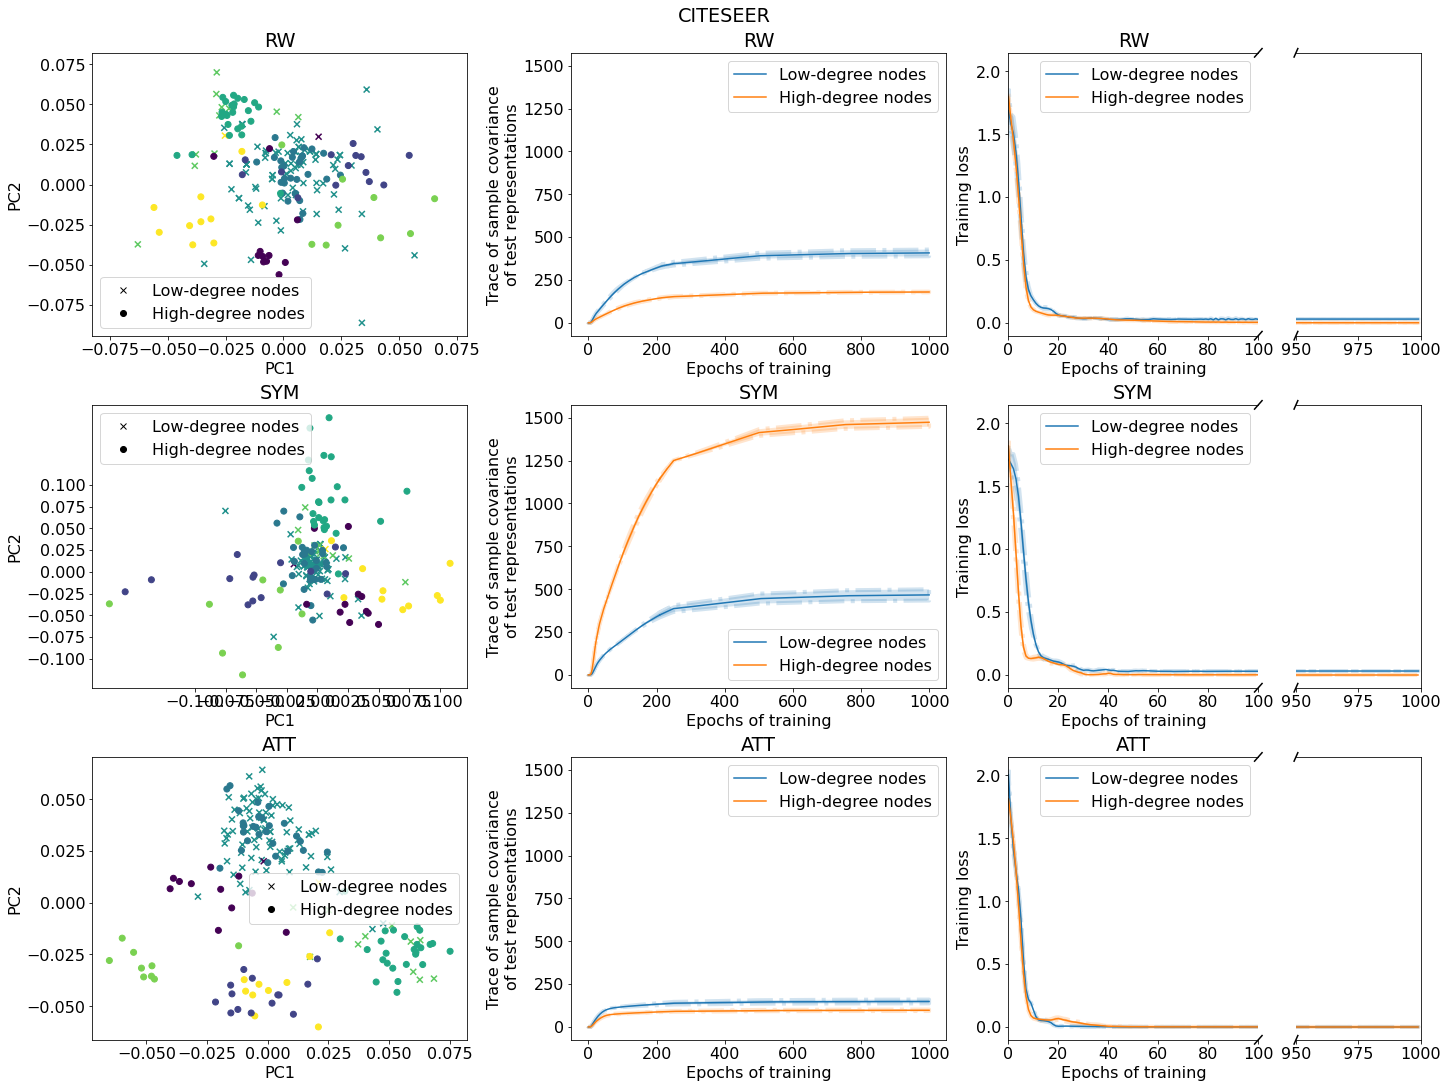

In [20]:
for models_type, models_to_plot in [('_', unfair_models_to_plot), ('_fair_', fair_models_to_plot[1:-1])]:
    
    if len(models_to_plot) == 0:
        continue
    
    fig, axs = plt.subplots(len(models_to_plot), 4, figsize=(20, 5 * len(models_to_plot)), constrained_layout=True, sharex='col', sharey='col', \
                       gridspec_kw={'width_ratios': [3, 3, 2, 1]})
    
    for idx, model_name in enumerate(models_to_plot):

        low_U0 = [e[0] for e in low_deg_svd[model_name][str(seeds_list[0])]]
        low_U1 = [e[1] for e in low_deg_svd[model_name][str(seeds_list[0])]]
        low_c = [e[2] for e in low_deg_svd[model_name][str(seeds_list[0])]]

        res = axs[idx, 0].scatter(low_U0, low_U1, c=low_c, marker='x', label='Low-degree nodes')

        high_U0 = [e[0] for e in high_deg_svd[model_name][str(seeds_list[0])]]
        high_U1 = [e[1] for e in high_deg_svd[model_name][str(seeds_list[0])]]
        high_c = [e[2] for e in high_deg_svd[model_name][str(seeds_list[0])]]

        axs[idx, 0].scatter(high_U0, high_U1, c=high_c, label='High-degree nodes')

        low_label = mlines.Line2D([], [], color='k', marker='x', ls='', label='Low-degree nodes')
        high_label = mlines.Line2D([], [], color='k', marker='o', ls='', label='High-degree nodes')
        axs[idx, 0].legend(handles=[low_label, high_label], prop={'size': 16})
        axs[idx, 0].set(xlabel='PC1', ylabel='PC2', title=model_name_map(model_name))

        axs[idx, 0].xaxis.set_tick_params(labelbottom=True)
        
        if idx > 0:
            axs[idx, 0].get_shared_x_axes().remove(axs[idx - 1, 0])
            axs[idx, 0].get_shared_y_axes().remove(axs[idx - 1, 0])
        
        ###

        low_y = [low_deg_spreads[model_name][seed] for seed in low_deg_spreads[model_name]]
        low_y_mean = np.array(low_y).mean(axis=0)
        low_y_std = np.array(low_y).std(axis=0)

        high_y = [high_deg_spreads[model_name][seed] for seed in high_deg_spreads[model_name]]
        high_y_mean = np.array(high_y).mean(axis=0)
        high_y_std = np.array(high_y).std(axis=0)

        axs[idx, 1].plot(low_y_mean, label='Low-degree nodes', color='C0')
        axs[idx, 1].fill_between(range(len(low_y_mean)), low_y_mean-low_y_std, low_y_mean+low_y_std,
                            alpha=0.2, edgecolor='C0', facecolor='C0',
                            linewidth=4, linestyle='dashdot', antialiased=True)
        axs[idx, 1].plot(high_y_mean, label='High-degree nodes', color='C1')
        axs[idx, 1].fill_between(range(len(high_y_mean)), high_y_mean-high_y_std, high_y_mean+high_y_std,
                            alpha=0.2, edgecolor='C1', facecolor='C1',
                            linewidth=4, linestyle='dashdot', antialiased=True)

        axs[idx, 1].set(xlabel='Epochs of training', ylabel='Trace of sample covariance\nof test representations', \
                        title=model_name_map(model_name))
        axs[idx, 1].legend(prop={'size': 16})
        
        axs[idx, 1].xaxis.set_tick_params(labelbottom=True)

        ###

        if idx > 0:
            axs[idx, 2].get_shared_x_axes().remove(axs[0, 2])
            axs[idx, 3].get_shared_x_axes().remove(axs[0, 3])
            axs[idx, 2].get_shared_y_axes().join(axs[idx, 2], axs[idx, 3])

        low_y = [low_deg_losses[model_name][seed] for seed in low_deg_losses[model_name]]
        low_y_mean = np.array(low_y).mean(axis=0)
        low_y_std = np.array(low_y).std(axis=0)

        high_y = [high_deg_losses[model_name][seed] for seed in high_deg_losses[model_name]]
        high_y_mean = np.array(high_y).mean(axis=0)
        high_y_std = np.array(high_y).std(axis=0)

        for ax in [axs[idx, 2], axs[idx, 3]]:
            ax.plot(low_y_mean, label='Low-degree nodes', color='C0')
            ax.fill_between(range(len(low_y_mean)), low_y_mean-low_y_std, low_y_mean+low_y_std,
                                alpha=0.2, edgecolor='C0', facecolor='C0',
                                linewidth=4, linestyle='dashdot', antialiased=True)
            ax.plot(high_y_mean, label='High-degree nodes', color='C1')
            ax.fill_between(range(len(high_y_mean)), high_y_mean-high_y_std, high_y_mean+high_y_std,
                                alpha=0.2, edgecolor='C1', facecolor='C1',
                                linewidth=4, linestyle='dashdot', antialiased=True)

        axs[idx, 2].set(xlabel='Epochs of training', ylabel='Training loss', \
                        title=model_name_map(model_name))
        axs[idx, 2].legend(prop={'size': 16})
        axs[idx, 2].set_xlim(0, 100)
        axs[idx, 3].set_xlim(args.epochs - 50, args.epochs)

        axs[idx, 2].spines['right'].set_visible(False)
        axs[idx, 3].spines['left'].set_visible(False)
        axs[idx, 3].set_yticks([])

        d = .015
        kwargs = dict(transform=axs[idx, 2].transAxes, color='k', clip_on=False)
        axs[idx, 2].plot((1-d, 1+d), (-d, +d), **kwargs)
        axs[idx, 2].plot((1-d, 1+d), (1-d, 1+d), **kwargs)

        kwargs.update(transform=axs[idx, 3].transAxes)
        axs[idx, 3].plot((-d, +d), (1-d, 1+d), **kwargs)
        axs[idx, 3].plot((-d, +d), (-d, +d), **kwargs)
        
        axs[idx, 2].xaxis.set_tick_params(labelbottom=True)
        axs[idx, 3].xaxis.set_tick_params(labelbottom=True)

    plt.suptitle(args.dataset.upper())
    plt.savefig('plots/{}_{}{}theorem_validation.pdf'.format(args.dataset, args.num_gnn_layers, models_type))
    plt.show()

In [21]:
csv = []

for model_name in model_list:
    print()
    print(model_name)
    
    fairness_scores = []
    util_scores = []
    for seed in seeds_list:
    
        mask = data.test_mask

        model = models[model_name][seed]
        out = model(data.x, data.edge_index, data.edge_attr)

        pred = F.log_softmax(out, dim=1)[mask]
        target = data.y[mask]
        err = -pred[range(target.size(0)), target].flatten()

        deg = degree(data.edge_index[0], num_nodes=data.x.size(0))[mask]
        err_by_deg = scatter_mean(err, deg.long())
        count_by_deg = scatter_sum(torch.ones_like(data.y)[mask].float(), deg.long())

        err_by_deg = err_by_deg[count_by_deg > 0]
        fairness_scores.append(torch.var(err_by_deg).item())       
        util_scores.append(torch.mean(err).item())
    
    csv.append([model_name_map(model_name), 'fairness', np.array(fairness_scores).mean(), np.array(fairness_scores).std()])
    csv.append([model_name_map(model_name), 'utility', np.array(util_scores).mean(), np.array(util_scores).std()])
    
    print('Fairness:', np.array(fairness_scores).mean(), '±', np.array(fairness_scores).std())
    print('Utility:', np.array(util_scores).mean(), '±', np.array(util_scores).std())


sage
Fairness: 0.5527014434337616 ± 0.011119812726974487
Utility: 1.8514505624771118 ± 0.02983546257019043

gcn
Fairness: 1.5372980833053589 ± 0.0053861141204833984
Utility: 2.4282058477401733 ± 0.007051825523376465

gat
Fairness: 0.06255926936864853 ± 0.006255835294723511
Utility: 0.632219135761261 ± 0.020149528980255127


In [22]:
import pandas as pd

pd.DataFrame(csv).to_csv('results/{}_{}.csv'.format(args.dataset, args.num_gnn_layers), header=False, index=False)

## Collision Probability

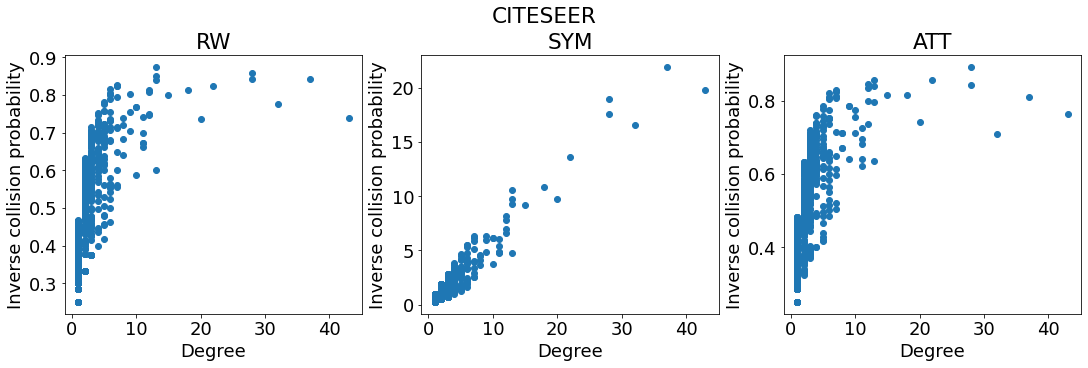

In [23]:
matplotlib.rcParams.update({'font.size': 18})

fig, axs = plt.subplots(1, len(unfair_models_to_plot), figsize=(5 * len(unfair_models_to_plot), 5), constrained_layout=True, sharex='col', sharey='col')

deg = degree(data.edge_index[0], num_nodes=data.x.size(0))[data.test_mask]

for idx, model_name in enumerate(unfair_models_to_plot):
    
    if model_name == 'gat':
        model = models[model_name][seeds_list[0]]
        out, atts = model(data.x, data.edge_index, data.edge_attr, get_att=True)

        t_edge_index = torch.cat([data.edge_index[1].reshape(1, -1), data.edge_index[0].reshape(1, -1)])
        pow_edge_index = t_edge_index.clone()
        n = data.x.size(0)
        pow_edge_index, pow_edge_weight = get_id(n, pow_edge_index)
        
        ent = torch_sparse.spmm(pow_edge_index, pow_edge_weight ** 2, data.y.size(0), data.y.size(0), torch.ones_like(data.y).reshape(-1, 1))
        for k in range(len(atts)):
            pow_edge_index, pow_edge_weight = torch_sparse.spspmm(t_edge_index, atts[k].flatten(), pow_edge_index, pow_edge_weight, n, n, n)
            ent += torch_sparse.spmm(pow_edge_index, pow_edge_weight ** 2, data.y.size(0), data.y.size(0), torch.ones_like(data.y).reshape(-1, 1))
    
    else:
        edge_index = data.edge_index
        edge_weight = torch.ones_like(edge_index[0]).float()

        _, deg_inv_sqrt = gcn_norm(edge_index, edge_weight, data.x.size(0), return_inv_sqrt=True)
        edge_weight = sage_norm(edge_index, edge_weight, data.x.size(0))

        deg = degree(edge_index[0], num_nodes=data.x.size(0))

        t_edge_index = torch.cat([edge_index[1].reshape(1, -1), edge_index[0].reshape(1, -1)])
        ent = torch.zeros_like(data.y).float()
        for l in range(args.num_gnn_layers + 1):
            pow_edge_index, pow_edge_weight = power(t_edge_index, edge_weight, data.y.size(0), k=l)
                
            if model_name == 'sage':
                agg = torch.ones_like(data.y).reshape(-1, 1)
            elif model_name == 'gcn':
                agg = (deg_inv_sqrt ** 2 * torch.ones_like(data.y)).reshape(-1, 1)
                
            ent += torch_sparse.spmm(pow_edge_index, pow_edge_weight ** 2, data.y.size(0), data.y.size(0), agg).flatten()

    axs[idx].scatter(deg[data.test_mask].tolist(), (1 / ent[data.test_mask]).tolist())
    axs[idx].set(xlabel=r'Degree', ylabel=r'Inverse collision probability', title=model_name_map(model_name))

plt.suptitle(args.dataset.upper())
plt.savefig('plots/{}_{}_icp_vs_deg.pdf'.format(args.dataset, args.num_gnn_layers))
plt.show()

In [24]:
matplotlib.rcParams.update({'font.size': 16})

fair_models_to_plot = [model_name for model_name in model_list if model_name.startswith('fair-')][1:-1]

if len(fair_models_to_plot) > 0:
    fig, axs = plt.subplots(1, len(fair_models_to_plot), figsize=(5 * len(fair_models_to_plot), 5), constrained_layout=True, sharex='col', sharey='col')

    ents = []

    deg = degree(data.edge_index[0], num_nodes=data.x.size(0))[data.test_mask]

    for model_name in ['gat'] + [model_name for model_name in model_list if model_name.startswith('fair-')]:
        model = models[model_name][seeds_list[0]]
        out, atts = model(data.x, data.edge_index, data.edge_attr, get_att=True)

        t_edge_index = torch.cat([data.edge_index[1].reshape(1, -1), data.edge_index[0].reshape(1, -1)])
        pow_edge_index = t_edge_index.clone()
        n = data.x.size(0)
        pow_edge_index, pow_edge_weight = get_id(n, pow_edge_index)

        ent = torch_sparse.spmm(pow_edge_index, pow_edge_weight ** 2, data.y.size(0), data.y.size(0), torch.ones_like(data.y).reshape(-1, 1))
        for k in range(len(atts)):
            pow_edge_index, pow_edge_weight = torch_sparse.spspmm(t_edge_index, atts[k].flatten(), pow_edge_index, pow_edge_weight, n, n, n)
            ent += torch_sparse.spmm(pow_edge_index, pow_edge_weight ** 2, data.y.size(0), data.y.size(0), torch.ones_like(data.y).reshape(-1, 1))
        ents.append(ent[data.test_mask])

    for k, model_name in enumerate(fair_models_to_plot):
        axs[k].scatter(deg.tolist(), ((1 / ents[k + 1]) / (1 / ents[0])).tolist())
        axs[k].axhline(y=1.0, color='C1', linestyle='--')

        axs[k].set(xlabel='Degree', ylabel='Ratio of inverse\ncollision probabilities', title=f"{model_name_map(model_name)} vs. {model_name_map('gat')}")

    plt.suptitle(args.dataset.upper())
    plt.savefig('plots/{}_{}_icp_ratio_vs_deg.pdf'.format(args.dataset, args.num_gnn_layers))
    plt.show()